### Add scripts path to the notebook

In [67]:
import sys
import os

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

c:\Users\yeget\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\notebooks


### Import Statements

In [68]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Load the data

In [69]:
PATH_TO_DATA = "../data/raw/MachineLearningRating_v3.txt"

In [70]:
data = pd.read_csv(filepath_or_buffer=PATH_TO_DATA, delimiter='|', low_memory=False)

### Data Cleaning

1) Find missing values

In [71]:
# find columns with na values
column_na_rations = data.isna().mean()

# print out columns that have missing values and the amount of missing values as percentages
column_na_rations[column_na_rations > 0].sort_values(ascending=False) * 100

NumberOfVehiclesInFleet    100.000000
CrossBorder                 99.930207
CustomValueEstimate         77.956560
WrittenOff                  64.183810
Converted                   64.183810
Rebuilt                     64.183810
NewVehicle                  15.327998
Bank                        14.594670
AccountType                  4.022806
Gender                       0.953507
MaritalStatus                0.825819
mmcode                       0.055195
VehicleType                  0.055195
make                         0.055195
VehicleIntroDate             0.055195
NumberOfDoors                0.055195
bodytype                     0.055195
kilowatts                    0.055195
cubiccapacity                0.055195
Cylinders                    0.055195
Model                        0.055195
CapitalOutstanding           0.000200
dtype: float64

2) Handle missing values

- drop columns with a lot of missing values, i.e greater than 50%

In [72]:
# find the columns with missing values greater than 50%
to_be_droped = column_na_rations[column_na_rations > 0.5].keys()

# drop the columns
data = data.drop(columns=to_be_droped)

- removes data for column with missing values less than 5%

In [73]:
# find the columns with missing values less than 5%
to_be_droped = column_na_rations[column_na_rations < 0.05].keys()

# drop the columns
data = data.dropna(subset=to_be_droped)

- For columns in between use mode or mean(depending on column data type) to replace the missing values

In [74]:
# find the columns with missing values greater than 5% and less than 50%
to_be_replaced = column_na_rations[(column_na_rations >= 0.05) & (column_na_rations <=0.5)].keys()

Find the data type of those columns

In [75]:
data[[*to_be_replaced]].dtypes

Bank          object
NewVehicle    object
dtype: object

Both are categorical so I will use their respective modes

In [76]:
for column in to_be_replaced:
    # Get the mode of the column
    mode_value = data[column].mode()[0]  
    # Fill missing values with the mode
    data[column] = data[column].fillna(mode_value)  

Finally check for the missing values

In [77]:
# find columns with na values
column_na_rations = data.isna().mean()

# print out columns that have missing values and the amount of missing values as percentages
column_na_rations[column_na_rations > 0].sort_values(ascending=False) * 100

Series([], dtype: float64)

## Goal of our modelling and it's relation to the business insights
## The goal of the modelling process is to predict OptimalPremium, which represents the ideal premium price for each customer based on their claims history and other features. This ensures profitability while maintaining competitive pricing.

## Contribution to Business Insight:

## Pricing Framework:
## The model helps align premiums with underlying risk, ensuring high-risk policies are priced higher and low-risk policies potentially cheaper. This minimizes losses and maximizes profitability.
## Marketing Strategy:
## By identifying profitable customer segments (e.g., newer vehicles, low-risk zones), the business can target these groups with competitive offers, discounts, or loyalty programs. Conversely, high-risk segments can be managed with stricter underwriting or higher deductibles.

# Feature Engineering  
## 1) I wanted to calculate the optimal premium values for every customer based on their TotalClaims. As this is a business money needs to be made and hence the premium price should at least give a return of 0, break even. So I will create a new feature , from TotalClaims and TotalPremium, called OptimumPremium.

In [78]:
# if the difference between totalPremium and totalClaims is negative then set the optimum premim = totalPremium + (TotalClaims - TotalPremium) else just make it equal to total premium
data['OptimalPremium'] = data['TotalPremium'] + np.minimum(0, data['TotalPremium'] - data['TotalClaims']) * -1

Check the result of the top 10 rows

In [79]:
data[['TotalClaims', 'TotalPremium', 'OptimalPremium']].sort_values(by='TotalClaims' , ascending=False).head(10)

,TotalClaims,TotalPremium,OptimalPremium
451249,393092.105263,243.538333,393092.105263
601844,376432.491228,562.617807,376432.491228
818316,363343.421053,1065.027982,363343.421053
173451,304338.657895,818.206140,304338.657895
172766,302361.149123,825.392281,302361.149123
402798,286686.431053,783.867018,286686.431053
803349,269311.929825,806.181579,269311.929825
904510,265789.473684,1060.473070,265789.473684
920077,263157.632807,857.887193,263157.632807
710484,261307.017544,1261.964035,261307.017544


2) Encode categorical values from the user information

In [80]:
# columns of car feature
car_features = ['Cylinders', 'NewVehicle', 'RegistrationYear', 'VehicleType', 'NumberOfDoors', 'kilowatts']

# columns of user location
location_features = ['Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone']

# columns of user information
user_features = ['Gender', 'MaritalStatus', 'AccountType', 'Citizenship']

# target columns
target_col = ['OptimalPremium']

# predictor columns
predict_col = [*car_features, *location_features, *user_features]

# combine features
all_features = [*car_features, *location_features, *user_features, *target_col]

In [81]:
# find categorical features
data_types = data[all_features].dtypes

categorical = []
numerical = []
for idx, dtype in enumerate(data_types):
    if dtype == object:
        categorical.append(all_features[idx])
    else:
        numerical.append(all_features[idx])

Now encode the features

In [82]:
new_df = pd.DataFrame()

In [83]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical feature
for col in categorical:
    # Apply LabelEncoder to each categorical column
    new_df[col] = label_encoder.fit_transform(data[col])

In [84]:
new_df[numerical] = data[numerical]

In [85]:
#let's see how our new dataframe looks like
new_df.head()

,NewVehicle,VehicleType,Country,Province,MainCrestaZone,SubCrestaZone,Gender,MaritalStatus,AccountType,Citizenship,Cylinders,RegistrationYear,NumberOfDoors,kilowatts,PostalCode,OptimalPremium
0,1,4,0,2,12,30,2,1,0,0,6.0,2004.0,4.0,130.0,1459.0,21.929825
1,1,4,0,2,12,30,2,1,0,0,6.0,2004.0,4.0,130.0,1459.0,21.929825
2,1,4,0,2,12,30,2,1,0,0,6.0,2004.0,4.0,130.0,1459.0,0.000000
3,1,4,0,2,12,30,2,1,0,0,6.0,2004.0,4.0,130.0,1459.0,512.848070
4,1,4,0,2,12,30,2,1,0,0,6.0,2004.0,4.0,130.0,1459.0,0.000000


In [86]:
new_df = new_df.dropna()

### Split the data

In [87]:
# get feature data
X = new_df[predict_col]

# get target data
y = new_df[target_col]

Split the data 80-20

In [88]:
x_train, x_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=.2)

### Train models

In [89]:
from scripts.training import train_and_log_model, initialize_mlflow, explain_model_with_shap

1) Initialize mlflow tracking uri

In [90]:
tracking_uri = "notebook"
experiment_name = "Optimum Price"
tracking_id = initialize_mlflow(uri=tracking_uri, experiment_name=experiment_name)

c:\Users\yeget\anaconda3\envs\eda-env\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


2) Train the models

In [91]:
# Models to train
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
}

In [92]:
# Store the best model
best_model = None
best_r2 = -float('inf')  # Initialize as negative infinity
best_mse = float('inf')  # Initialize MSE as positive infinity

In [96]:
# Train each model and log with MLflow
for model_name, model in models.items():
    print(f"Training {model_name}...")
    mse, r2, trained_model = train_and_log_model(model, model_name,tracking_id, x_train, y_train, x_test, y_test)
    print(f"{model_name} - MSE: {mse}, R2: {r2}\n")
    
    # Compare based on r2 score (or you can change to mse)
    if r2 > best_r2:
        best_r2 = r2
        best_mse = mse
        best_model = trained_model

Training LinearRegression...


2025/12/09 22:31:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


LinearRegression - MSE: 4574656.425240915, R2: 7.257203001675983e-05

Training RandomForestRegressor...


2025/12/09 22:37:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RandomForestRegressor - MSE: 5022460.856933857, R2: -0.09780842535935608

Training GradientBoostingRegressor...


2025/12/09 22:39:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


GradientBoostingRegressor - MSE: 4575187.1678237375, R2: -4.34375707976109e-05

Training DecisionTreeRegressor...


2025/12/09 22:39:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


DecisionTreeRegressor - MSE: 5078212.839518978, R2: -0.10999468184912753



In [94]:
# Print out the best model's results
print(f"Best model: {best_model.__class__.__name__}")
print(f"Best R2 Score: {best_r2}")
print(f"Best MSE: {best_mse}")

Best model: LinearRegression
Best R2 Score: 7.257203001675983e-05
Best MSE: 4574656.425240915


## Interpreting model evaluation and metrics 
## Model comparison
Four regression algorithms were trained to predict OptimalPremium: Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, and Decision Tree Regressor. Performance was evaluated on the test set using R² (explained variance) and MSE (mean squared error):

Linear Regression

MSE ≈ 4.57M
R² ≈ 0.00007
This model is the least bad: its error is the lowest and its R² is just above zero, meaning it performs only marginally better than predicting the average premium for everyone. It captures almost no meaningful structure in the data.
Gradient Boosting Regressor

MSE ≈ 4.58M
R² ≈ –0.00004
Error is similar to Linear Regression, but the slightly negative R² indicates it does worse than a simple mean benchmark. Adding non‑linear trees does not bring additional predictive power for the current features and target.
Random Forest Regressor

MSE ≈ 5.02M
R² ≈ –0.098
Both the error and the negative R² show that the random forest clearly underperforms the baseline. The model overfits noise in the training data and fails to generalise.
Decision Tree Regressor

MSE ≈ 5.08M
R² ≈ –0.110
This is the weakest model: it has the largest error and the most negative R², again signalling severe overfitting and no useful generalisation.
Overall conclusion: none of the models currently provide strong predictive performance for OptimalPremium. Linear Regression is selected as the “best” model only because it has the smallest MSE and the least negative/closest‑to‑zero R², but in practice its predictions should be treated as approximate and the model should be used mainly for directional insights (e.g. via SHAP) rather than as a production pricing engine.

### Explain the model

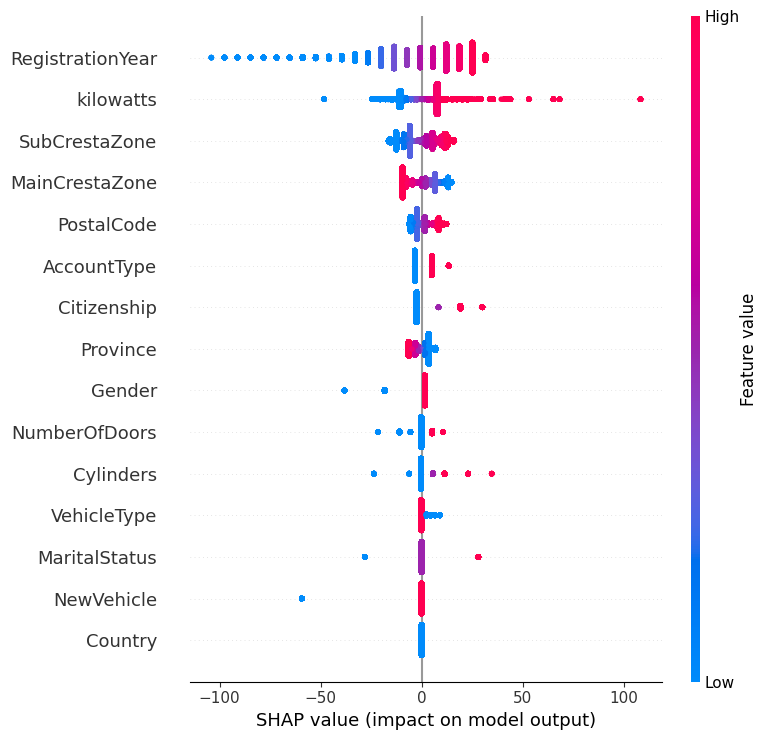

In [95]:
# Generate SHAP explanations for the best model
shap_values = explain_model_with_shap(best_model, x_train, x_test)

#### Visual Interpretation

- Y-Axis (Features): Lists the features used in the model, such as RegistrationYear, kilowatts, MainCrestaZone, SubCrestaZone, Province, AccountType, PostalCode, Citizenship, Gender, NumberOfDoors, VehicleType, MaritalStatus, NewVehicle, Cylinders, and Country.
- X-Axis (SHAP Value): Represents the impact of each feature on the model’s output. The values range from approximately -100 to 100.

    *  Positive SHAP Values (bars extending to the right): Indicate that higher values of the feature increase the model’s prediction.
    *  Negative SHAP Values (bars extending to the left): Indicate that higher values of the feature decrease the model’s prediction.
    *  Color Gradient: The color of the bars ranges from blue (low feature value) to red (high feature value), showing the magnitude of the feature’s value.

#### Result Insights
- RegistrationYear and kilowatts have significant impacts on the model’s predictions, with both positive and negative SHAP values.
- MainCrestaZone and SubCrestaZone also show notable impacts, suggesting these features are important for the model.
- Features like Province, AccountType, and PostalCode have moderate impacts.
- Gender, Citizenship, and NumberOfDoors have smaller impacts compared to other features.

## Deeper Business Insights and recommendations 

## Based on the SHAP analysis, the following insights and recommendations can be derived:

## RegistrationYear
Insight:
Newer vehicles (higher RegistrationYear) tend to reduce the optimal premium, while older vehicles slightly increase it. This suggests newer cars are less risky, likely due to better safety features and fewer mechanical failures.
Recommendation:
Adjust pricing relativities by vehicle age:
Offer small discounts for newer vehicles.
Apply surcharges for older vehicles.
Target customers with newer vehicles for marketing campaigns, as they are likely to be lower-risk and more profitable.

## kilowatts
Insight:
Higher kilowatt values (more powerful engines) increase the optimal premium, while lower kilowatt values reduce it. This indicates high-power vehicles are riskier, likely due to higher accident severity or repair costs.
Recommendation:
Use engine power explicitly in pricing:
Apply higher premiums for high-power vehicles.
Offer discounts for low-power vehicles.
Position “safe driver” or “economical car” products for low-power vehicles to attract low-risk customers.

## SubCrestaZone
Insight:
SubCrestaZone has moderate SHAP impact, suggesting local territory differences in risk. Some zones consistently push premiums higher, while others reduce them.
Recommendation:
Use SubCrestaZone as the primary geographic rating factor instead of broader categories like Province or PostalCode.
Aggregate SHAP values by SubCrestaZone to identify high-risk zones (higher premiums) and low-risk zones (competitive pricing opportunities).

## Limitations of the Model and Future Work

## Limitations:
## Low Predictive Power:
The best model (Linear Regression) has an R² ≈ 0.00007, meaning it explains almost none of the variation in OptimalPremium. Predictions are not reliable for production use.
## Limited Features:
Key insurance-related features like vehicle value, cover types, deductibles, prior claims, and policy tenure were not included, which limits the model’s ability to capture risk.
##  Encoding Issues:
Label encoding for categorical variables may oversimplify relationships, especially for geographic and vehicle categories.

## Future Work / Next Steps:
## Expand Predictor Columns:

Include richer features such as CustomValueEstimate, SumInsured, cover types, deductibles, prior claims, policy tenure, vehicle usage (private/commercial), make/model, and driver age.
Avoid target leakage by excluding columns directly derived from TotalPremium or TotalClaims.
## Improve Feature Encoding:

Use one-hot encoding or target encoding for categorical variables to better capture relationships.
## Alternative Targets:

Model pure premium (expected claim cost) or loss ratio instead of OptimalPremium for more robust pricing insights.
## Deeper SHAP Analysis:

Aggregate SHAP values by category (e.g., SubCrestaZone, Make, VehicleType) to create actionable pricing tables.
Use SHAP dependence plots to quantify the impact of features (e.g., “each 10-year increase in RegistrationYear reduces premium by R X”).
## Model Refinement:
Experiment with non-linear models (e.g., XGBoost, LightGBM) and hyperparameter tuning to improve predictive accuracy.
Use cross-validation to ensure generalizability.